In [1]:
import numpy as np

import matplotlib.pyplot as plt 

from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

%matplotlib inline

In [2]:
(cifar_train, _), (cifar_test, _) = cifar10.load_data()

size = 32
channel = 3
# scaling input data
cifar_train = cifar_train / 255
cifar_test = cifar_test / 255

# Adding noise mean = 0, std = 0.3
noise = 0.3
cifar_train_noise = cifar_train + noise * np.random.normal(0, 0.3, size=cifar_train.shape) 
cifar_test_noise = cifar_test + noise * np.random.normal(0, 0.3, size=cifar_test.shape)

cifar_train_noise = np.clip(cifar_train_noise, 0, 1)
cifar_test_noise = np.clip(cifar_test_noise, 0, 1)

170500096/170498071 [==============================] - 5s 0us/step


### Sample few noisy and original images

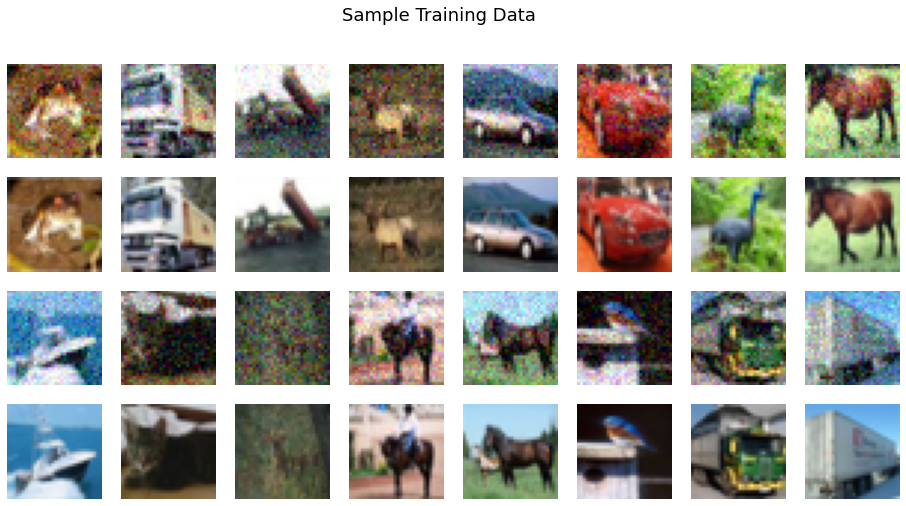

In [3]:
# Visualize few training images with their noisy images

rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)
plt.savefig("Cifar-trian.png")

plt.show()

In [4]:
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU
from keras.optimizers import Adam

In [5]:
# Encoder 
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# Training
epochs = 25
batch_size = 256

history = autoencoder.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test)
               )

Epoch 1/25
196/196 [==============================] - 4s 21ms/step - loss: 0.5800 - val_loss: 0.6177
Epoch 2/25
196/196 [==============================] - 4s 19ms/step - loss: 0.5619 - val_loss: 0.5771
Epoch 3/25
196/196 [==============================] - 4s 19ms/step - loss: 0.5600 - val_loss: 0.5621
Epoch 4/25
196/196 [==============================] - 4s 19ms/step - loss: 0.5591 - val_loss: 0.5583
Epoch 5/25
196/196 [==============================] - 4s 19ms/step - loss: 0.5586 - val_loss: 0.5572
Epoch 6/25
196/196 [==============================] - 4s 18ms/step - loss: 0.5582 - val_loss: 0.5565
Epoch 7/25
196/196 [==============================] - 4s 18ms/step - loss: 0.5579 - val_loss: 0.5561
Epoch 8/25
196/196 [==============================] - 3s 18ms/step - loss: 0.5577 - val_loss: 0.5568
Epoch 9/25
196/196 [==============================] - 3s 18ms/step - loss: 0.5575 - val_loss: 0.5559
Epoch 10/25
196/196 [==============================] - 4s 18ms/step - loss: 0.5574 - val_lo

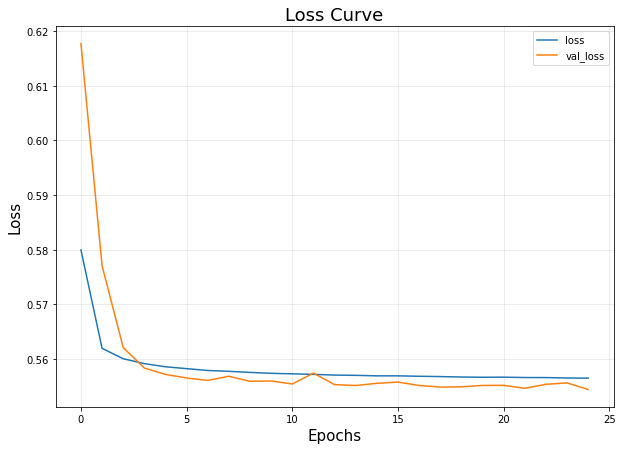

In [7]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()

In [8]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, cifar_test_noise.shape[0]-48) 

cifar_test_images = cifar_test_noise[rand:rand+num_imgs] # slicing
cifar_test_desoided = autoencoder.predict(cifar_test_images) # predict

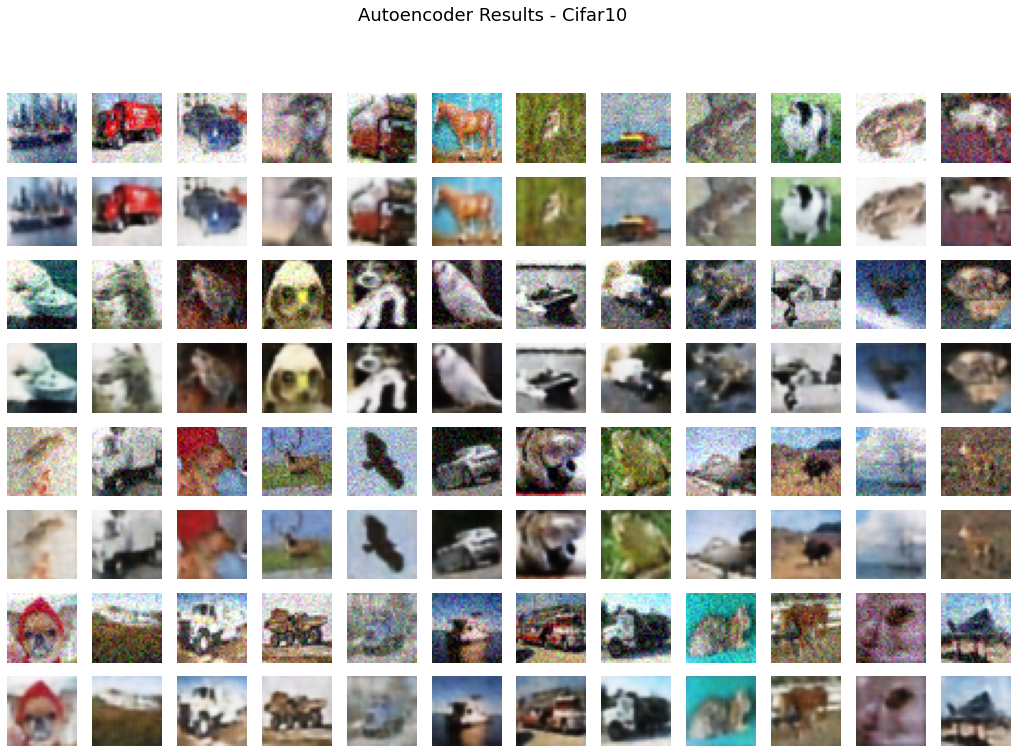

In [20]:
# Visualize test images with their denoised images

rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_desoided[i*cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("test_results_cifar10.png")

plt.show()

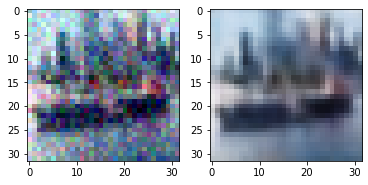

In [17]:
plt.figure(1)
plt.subplot(121)
plt.imshow(cifar_test_images[0])

plt.subplot(122)
plt.imshow(cifar_test_desoided[0])
plt.show()

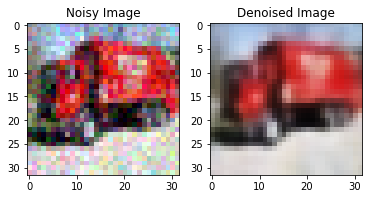

In [29]:
plt.figure(1)
plt.subplot(121)
plt.imshow(cifar_test_images[1])
plt.title('Noisy Image')
plt.subplot(122)
plt.imshow(cifar_test_desoided[1])
plt.title('Denoised Image')
plt.show()

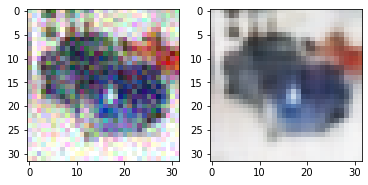

In [21]:
plt.figure(1)
plt.subplot(121)
plt.imshow(cifar_test_images[2])

plt.subplot(122)
plt.imshow(cifar_test_desoided[2])
plt.show()

In [ ]:
plt.figure(1)
plt.subplot(121)
plt.imshow(cifar_test_images[3])

plt.subplot(122)
plt.imshow(cifar_test_desoided[3])
plt.show()